In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_pos_maps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
from ripple_heterogeneity.place_cells import maps
from scipy import stats
from scipy.stats import zscore

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_GG_GG0401.pkl"
with open(basepath, "rb") as f:
    results = pickle.load(f)

In [3]:
position_df = loading.load_animal_behavior(results['react'].basepath)


In [4]:
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

pos = nel.PositionArray(data=position_df_no_nan[["x","y"]].values.T,timestamps=position_df_no_nan.timestamps.values)

In [5]:
assembly_act_task = results["react"].get_assembly_act(epoch=results["react"].epochs[0])


In [36]:
tc = maps.TuningCurve2DContinuous(asa=assembly_act_task, pos=pos,sigma=3)


In [26]:
_, assembly_df, keep_assembly = assembly_multi_region.compile_results_df(results)
assembly_df

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
0,0.025007,False,0,1,Pyramidal Cell,PFC,unknown,NaN
1,-0.031789,False,0,2,Pyramidal Cell,PFC,unknown,NaN
2,-0.047907,False,0,3,Pyramidal Cell,PFC,unknown,NaN
3,-0.059820,False,0,4,Pyramidal Cell,PFC,unknown,NaN
4,0.017445,False,0,5,Pyramidal Cell,PFC,unknown,NaN
...,...,...,...,...,...,...,...,...
233,-0.007909,False,6,32,Pyramidal Cell,CA1,middle,0.0
234,0.071459,False,6,35,Pyramidal Cell,CA1,middle,0.0
235,-0.059559,False,6,36,Pyramidal Cell,CA1,Deep,-60.0
236,0.060810,False,6,37,Pyramidal Cell,CA1,Deep,-40.0


In [31]:
counts_df = (
    assembly_df.groupby(["assembly_n", "is_member_sig"])
    .apply(
        lambda x: pd.Series(
            {
                "n_deep": (x.deepSuperficial == "Deep").sum(),
                "n_sup": (x.deepSuperficial == "Superficial").sum(),
                "n_mec": (
                    x.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")
                ).sum(),
                "n_pfc": (x.brainRegion.str.contains("PFC")).sum(),
            }
        )
    )
    .reset_index()
)
counts_df.query("is_member_sig")

,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,0,0
3,1,True,3,0,0,5
5,2,True,2,1,0,0
7,3,True,1,0,0,5
9,4,True,1,0,0,5
11,5,True,1,0,0,1
13,6,True,0,0,0,3


In [40]:
assembly_df.query("assembly_n == 3 & is_member_sig")

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
108,-0.473226,True,3,7,Pyramidal Cell,PFC,unknown,NaN
110,-0.234509,True,3,9,Pyramidal Cell,PFC,unknown,NaN
112,-0.337285,True,3,11,Pyramidal Cell,PFC,unknown,NaN
113,-0.397867,True,3,12,Pyramidal Cell,PFC,unknown,NaN
114,-0.513562,True,3,13,Pyramidal Cell,PFC,unknown,NaN
122,-0.241480,True,3,21,Pyramidal Cell,CA1,Deep,-100.0


In [35]:
tc_unit = maps.SpatialMap(pos=pos,st=results["react"].st,dim=2)

In [41]:
np.where(results["react"].cell_metrics.UID == 7)

(array([6], dtype=int64),)

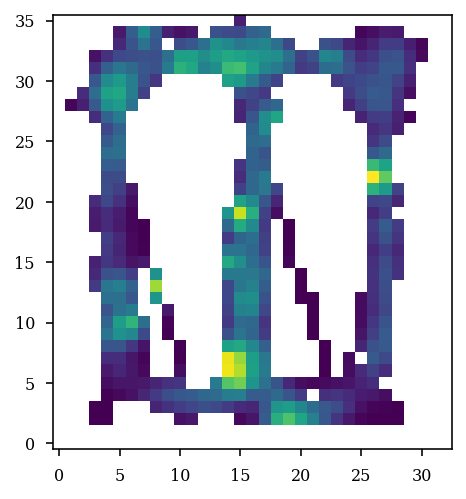

In [54]:
ratemap = tc_unit.tc.ratemap[6,:,:]
ratemap[tc_unit.tc.occupancy < 0.1] = np.nan
plt.imshow(ratemap, origin="lower")

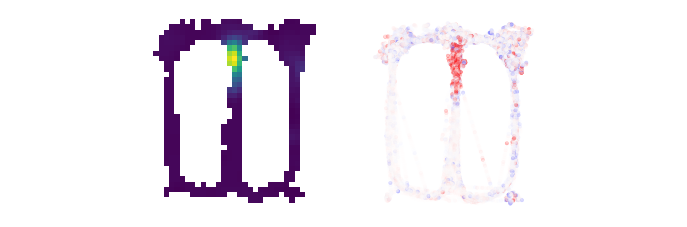

In [57]:

uu = 2

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=1, subplots=(1,2)), edgecolor=None)
fig.subplots_adjust(hspace = 0, wspace=-0.5)
ax = axs.ravel()

# fig, ax = plt.subplots(1, 2,figsize=functions.set_size("thesis", fraction=0.5, subplots=(1, 2)))
ax[0].imshow(tc.ratemap[uu, :, :], origin="lower")
# ax[0].colorbar()
ax[0].axis("equal")

colors = np.interp(
    position_df_no_nan.time.values,
    assembly_act_task.abscissa_vals,
    assembly_act_task.data[uu],
)
ax[1].scatter(
    position_df_no_nan.y,
    position_df_no_nan.x,
    s=3,
    c=colors,
    alpha=0.25,
    cmap="bwr",
    norm=norm,
    rasterized=True
)
ax[1].axis("equal")

ax[0].axis("off")
ax[1].axis("off")

# sns.despine(bottom=True,left=True)
plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_example.svg"),
    dpi=300,
    bbox_inches="tight",
)

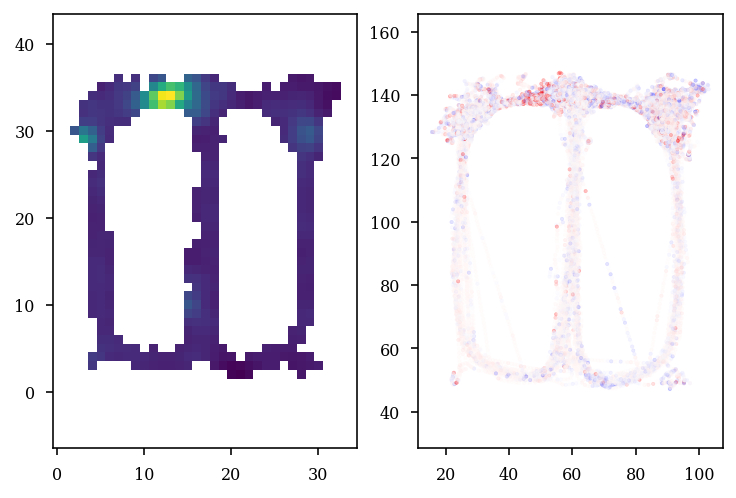

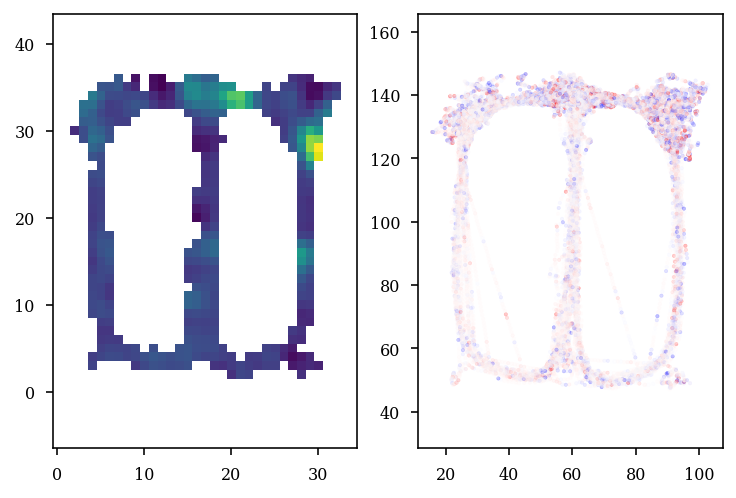

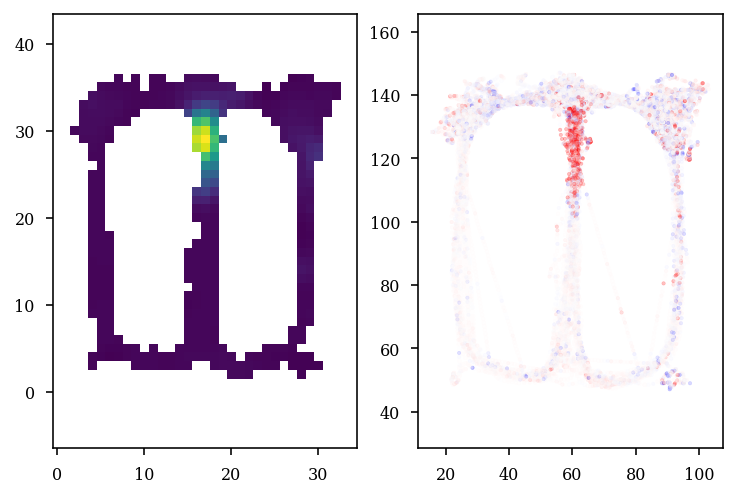

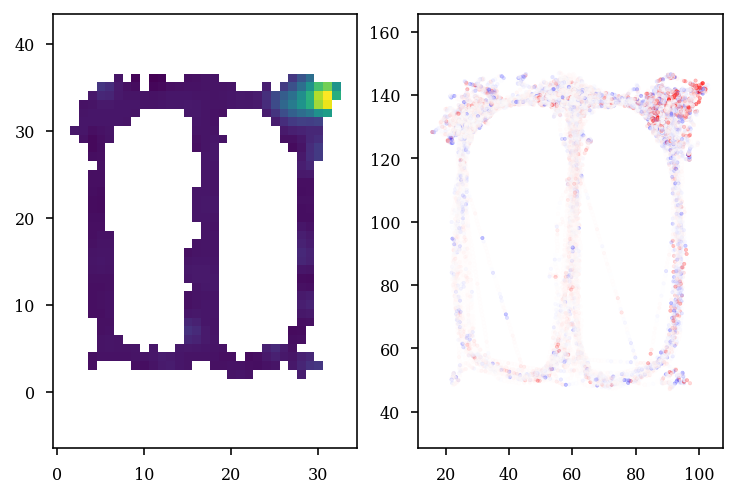

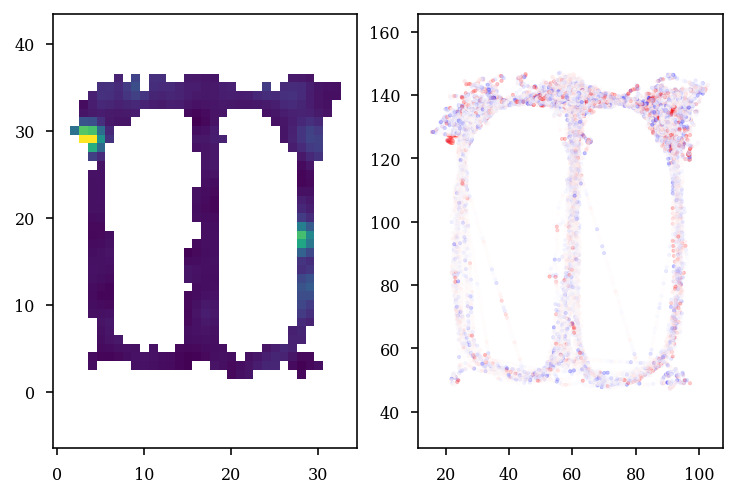

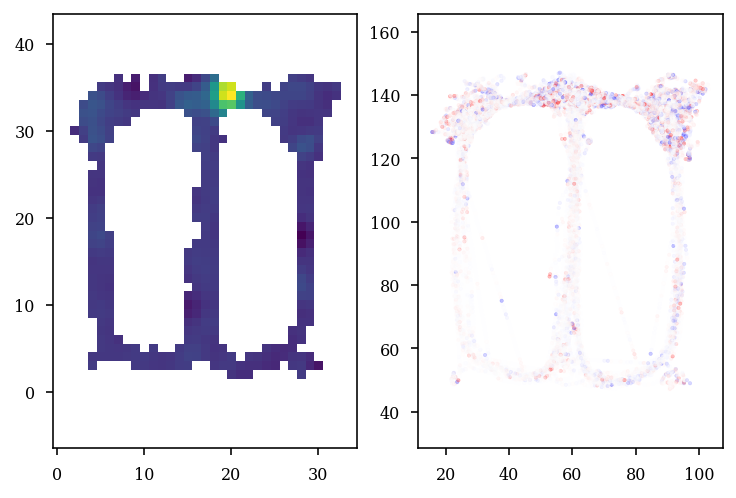

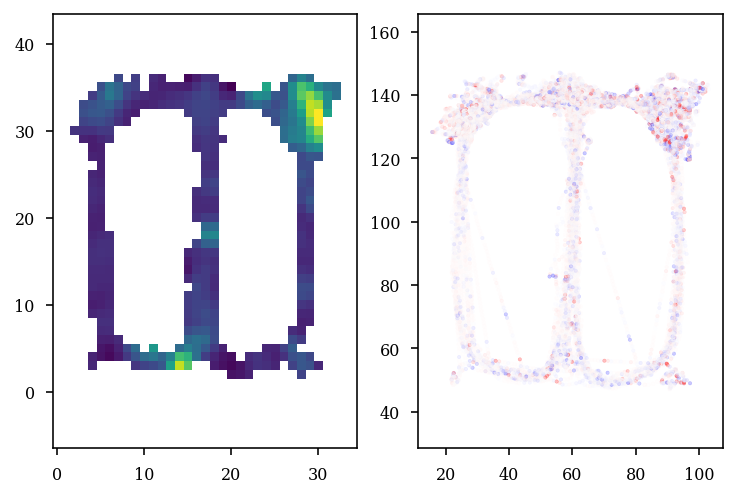

In [7]:
import matplotlib as mpl

position_df_no_nan = position_df.query("not x.isnull()")
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)

for uu in range(assembly_act_task.n_signals):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tc.ratemap[uu, :, :], origin="lower")
    # ax[0].colorbar()
    ax[0].axis("equal")

    colors = np.interp(
        position_df_no_nan.time.values,
        assembly_act_task.abscissa_vals,
        assembly_act_task.data[uu],
    )
    ax[1].scatter(
        position_df_no_nan.y,
        position_df_no_nan.x,
        s=3,
        c=colors,
        alpha=0.25,
        cmap="bwr",
        norm=norm,
    )
    ax[1].axis("equal")